Libraries used:

In [1]:
import graph_tool.all as gt
import numpy as np
import multiprocessing as mp
import scipy.spatial as sp

Global variables:

- file: contains the file's path.

In [2]:
file2 = "/home/imane/Desktop/PFE2020/file/DirectedWeighted/TestFile.gml"
file1 = "/home/imane/Desktop/PFE2020/file/DirectedWeighted/TestFile2.gml"

Defining functions:

- createGraph(file): takes the file's path as an input and returns the graph as a Graph tool object.

- drawGraph(file): takes a graph tool graph and draw it on screen.

- vectoreBasedSignature(Graph, adj, output): takes a graph, its adjacency matrix and a the variable output of     type Queue to store the result in it. This function returns a queue containing the vector based signature     matrix of all nodes of the graph.

In [3]:
def createGraph(file):
    graph = gt.load_graph(file)
    #gt.load_graph("graph.graphml", fmt="xml")
    print(graph)
    return graph

def drawGraph(Graph):
    gt.graph_draw(Graph)
    #return mainGraph
    #gt.graph_draw(Graph, vertex_text = Graph.vertex_properties.label, vertex_font_size= 17, output=None, 
                  #edge_font_size = 17, edge_text= Graph.edge_properties.value)
    
def vectoreBasedSignature(Graph, adj, output):
    
    #Transforming the matrix to a numpy 2D array
    adjA = adj.toarray()
    
    #Size of the adj array
    adjAsize = len(adjA)
    
    #Get the max degree of a vector in a graph 
    degMax = int(Graph.get_total_degrees(Graph.get_vertices()).max()) 
    
    #Creating the vector based signature matrix (contains the vector based signature of all nodes)
    vbsM = np.zeros((adjAsize, degMax + 1)) 
    
    #NOTE:in case I wanted to make the vbsM of equal size (size(col) = size(row))then I'll just have to change
     #the following line to: vbsM = numpy.empty((adjAsize, degMax + 1)) to numpy.zeros((adjAsize, adjAsize))

    listofweights = []
    
    #initializing col of vbsM
    row = 0

    for rowId in range(adjAsize):
        
        #initializing col of vbsM to 1 so that we don't put a weight in place of the vertex's degree.
        col = 1
        
        #Calculating the degree of each vertex.
        degree = adj.getrow(rowId).getnnz() #getnnz() gives the size of an array
        
        #placing the degrees in the head of each row.
        vbsM[rowId][0] = degree
        
        for colId in range(adjAsize):
            
            if(adjA[rowId][colId] > 0):
                listofweights.append(adjA[rowId][colId])

        #We sort the list of weights in a descending order
        listofweights.sort(reverse=True)

        #We add the sorted weights to the vector based signature matrix
        for weight in listofweights:
            vbsM[row][col] = weight
            col = col + 1
            
        #We empty the list after each iteration
        listofweights = []
        row = row + 1
        
    #print("The vector based signature matrix: \n", vbsM)    
    return output.put(vbsM)   

Main program:

<Graph object, undirected, with 5 vertices and 8 edges at 0x7fd508cb3a50>
<Graph object, undirected, with 4 vertices and 4 edges at 0x7fd518bd8c50>


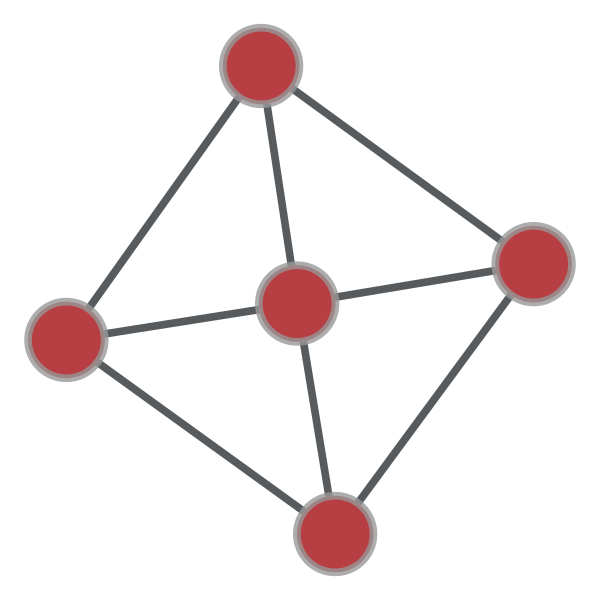

directed       (graph)   (type: double, val: 0.0)
label          (vertex)  (type: string)
value          (edge)    (type: double)


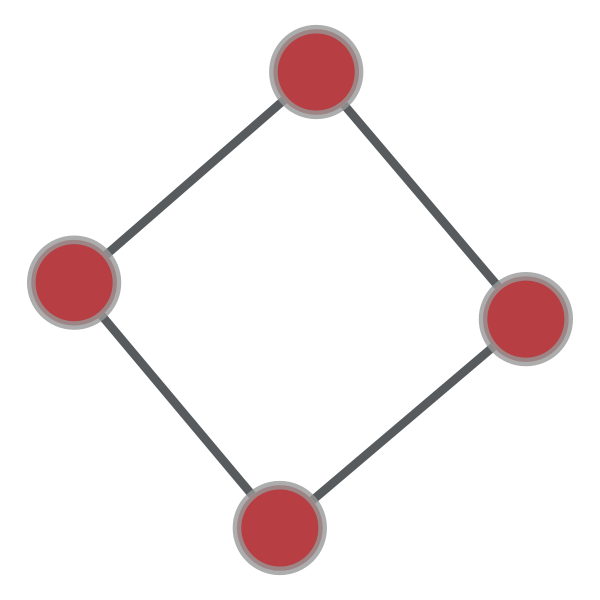

directed       (graph)   (type: double, val: 0.0)
label          (vertex)  (type: string)
value          (edge)    (type: double)


In [4]:
#Create the two graphs
Graph1, Graph2 = createGraph(file1), createGraph(file2)

#drawing first graph and showing its properties
drawGraph(Graph1)
Graph1.list_properties()

#drawing second graph and showing its properties
drawGraph(Graph2)
Graph2.list_properties()

Getting the adjecency matrix of each graph (using Graph Tool function):

In [5]:
adj1 = gt.adjacency(Graph1, weight = Graph1.edge_properties.value)
print("Adjacency Matrix of Graph 1: \n",adj1.toarray(), "\n")

print(Graph2.edge_properties)
adj2 = gt.adjacency(Graph2, weight = Graph2.edge_properties.value)
print("Adjacency Matrix of Graph 2: \n",adj2.toarray())

Adjacency Matrix of Graph 1: 
 [[0.  0.5 0.  0.3 0.3]
 [0.5 0.  0.2 0.  0.3]
 [0.  0.2 0.  0.7 1.3]
 [0.3 0.  0.7 0.  1.5]
 [0.3 0.3 1.3 1.5 0. ]] 

{'value': <EdgePropertyMap object with value type 'double', for Graph 0x7fd518bd8c50, at 0x7fd518a80a10>}
Adjacency Matrix of Graph 2: 
 [[0.  0.5 0.  0.3]
 [0.5 0.  0.1 0. ]
 [0.  0.1 0.  0.9]
 [0.3 0.  0.9 0. ]]


Putting the graphs and their adjacency matrices in a list for multiprocessing purposes:

In [6]:
listofgraphs = [Graph1, Graph2]
listofadj = [adj1, adj2]

Applying the vectorBasedSignature function on Graph1 and Graph2 in parallel: 

In [7]:
output = mp.Queue()

vbsm = []
for i in range(2):
    p = mp.Process(target = vectoreBasedSignature, args = (listofgraphs[i], listofadj[i], output))
    p.start()
    vbsm.append(output.get())
    
print(vbsm)    

[array([[3. , 0.5, 0.3, 0.3, 0. ],
       [3. , 0.5, 0.3, 0.2, 0. ],
       [3. , 1.3, 0.7, 0.2, 0. ],
       [3. , 1.5, 0.7, 0.3, 0. ],
       [4. , 1.5, 1.3, 0.3, 0.3]]), array([[2. , 0.5, 0.3],
       [2. , 0.5, 0.1],
       [2. , 0.9, 0.1],
       [2. , 0.9, 0.3]])]


The cost matrix:
1. Store the two elements of the list in different variables.

In [8]:
vbs1 = vbsm[0]

vbs2 = vbsm[1]

print(vbs1)
print(vbs2)

[[3.  0.5 0.3 0.3 0. ]
 [3.  0.5 0.3 0.2 0. ]
 [3.  1.3 0.7 0.2 0. ]
 [3.  1.5 0.7 0.3 0. ]
 [4.  1.5 1.3 0.3 0.3]]
[[2.  0.5 0.3]
 [2.  0.5 0.1]
 [2.  0.9 0.1]
 [2.  0.9 0.3]]


2. Calculating the cost matrix:

   The cost matrix's size is: (size(Graph1), size(Graph2)).
   
   We use the Manhattan distance to fill the cost matrix.

In [26]:
#calculating the size of the cost matrix
rowC = len(Graph1.get_vertices())
colC = len(Graph2.get_vertices())

#initializing the cost matrix
costMatrix = np.zeros((rowC, colC))

#Equalize the size of vbs1 and vbs2 to be able to use the predefined function cityblock (Manhattan distance)
vbs1size = len(vbs1[0])
vbs2size = len(vbs2[0])
print(vbs1size, vbs2size)
#Calculate the amount of columns to add to the smallest matrix so that size(vbs1) == size(vbs2)
add = 0
add = abs(vbs2size - vbs1size)
print(add)
#We use np.lib.pad to pad zeros around the smallest matrix
if(vbs1size > vbs2size):
    print("yes1")
    vbs1copy = vbs1
    for i in range(add):
        vbs2copy = np.lib.pad(vbs2, ((0,0),(0,add)), 'constant', constant_values=(0))
elif(vbs1size < vbs2size):
    print("yes2")
    vbs2copy = vbs2
    for i in range(add):
        vbs1copy = np.lib.pad(vbs1, ((0,0),(0,add)), 'constant', constant_values=(0)) 
else:
    vbs1copy = vbs1
    vbs2copy = vbs2

print("The new matrices: \n vbs1 =  \n", vbs1copy, "\n vbs2 = \n", vbs2copy )        

5 3
2
yes1
The new matrices: 
 vbs1 =  
 [[3.  0.5 0.3 0.3 0. ]
 [3.  0.5 0.3 0.2 0. ]
 [3.  1.3 0.7 0.2 0. ]
 [3.  1.5 0.7 0.3 0. ]
 [4.  1.5 1.3 0.3 0.3]] 
 vbs2 = 
 [[2.  0.5 0.3 0.  0. ]
 [2.  0.5 0.1 0.  0. ]
 [2.  0.9 0.1 0.  0. ]
 [2.  0.9 0.3 0.  0. ]]


In [27]:
for i in range(rowC):
    for j in range(colC):    
        costMatrix[i][j] = sp.distance.cityblock(vbs1copy[i], vbs2copy[j])
print("The cost matrix: \n", costMatrix)

The cost matrix: 
 [[1.3 1.5 1.9 1.7]
 [1.2 1.4 1.8 1.6]
 [2.4 2.6 2.2 2. ]
 [2.7 2.9 2.5 2.3]
 [4.6 4.8 4.4 4.2]]


#TO_DO: program the Hungarian method.

The Hungarian program:

First, we must make the cost matrix in a square shape:

In [65]:
#Claculate the number of columns of the cost matrix
csCol = len(costMatrix[0])
#Claculate the number of rows of the cost matrix
csRow = len(costMatrix)
#Calculate the number of 0 to add to the 
add2 = abs(csCol - csRow)
print(add2)
if (csCol > csRow):
    paddedCostMatrix = np.lib.pad(costMatrix, ((0,add2),(0,0)), 'constant', constant_values=(0))
    print(paddedCostMatrix)
elif (csCol < csRow):
    paddedCostMatrix = np.lib.pad(costMatrix, ((0,0),(0,add2)), 'constant', constant_values=('0'))
    print(paddedCostMatrix)

1
[[0.  0.2 0.6 0.4 0. ]
 [1.2 1.4 1.8 1.6 0. ]
 [2.4 2.6 2.2 2.  0. ]
 [2.7 2.9 2.5 2.3 0. ]
 [4.6 4.8 4.4 4.2 0. ]]


In [57]:
import munkres as ms

In [66]:
m = ms.Munkres()
print(m)
print(costMatrix)
indexes = m.compute(costMatrix)
print(indexes)
ms.print_matrix(costMatrix, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = costMatrix[row][column]
    total += value
    print(f'({row}, {column}) -> {value}')
print(f'total cost: {total}')

[[0.  0.2 0.6 0.4]
 [1.2 1.4 1.8 1.6]
 [2.4 2.6 2.2 2. ]
 [2.7 2.9 2.5 2.3]
 [4.6 4.8 4.4 4.2]]


IndexError: index 4 is out of bounds for axis 0 with size 4